In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 7 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 300.0

ng = 7

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   1,   3 /)

data wgt
     &     /.55, .55, .85,
     &     .85,
     &     0, .3, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'trp75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

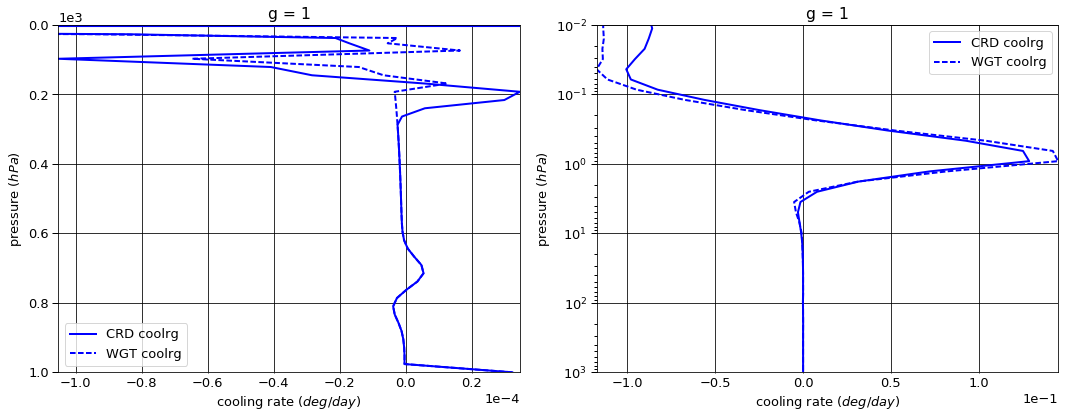

# Figure: cooling rate g-group 2

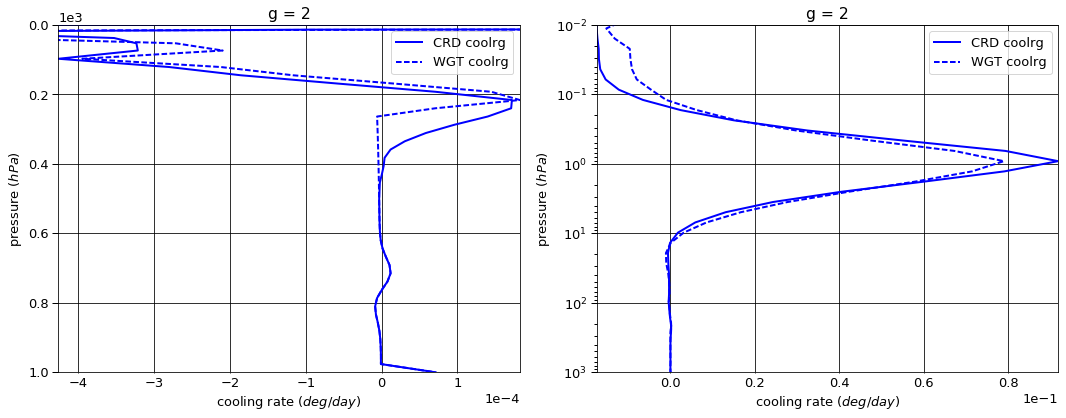

# Figure: cooling rate g-group 3

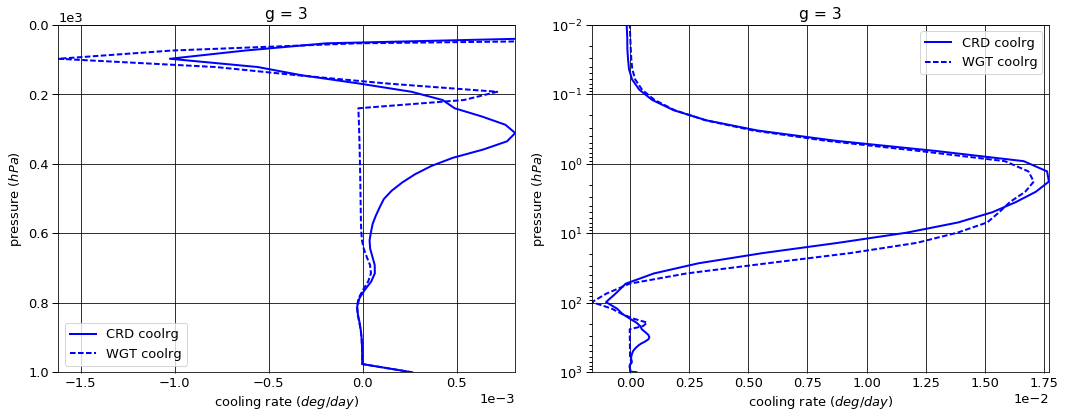

# Figure: cooling rate g-group 4

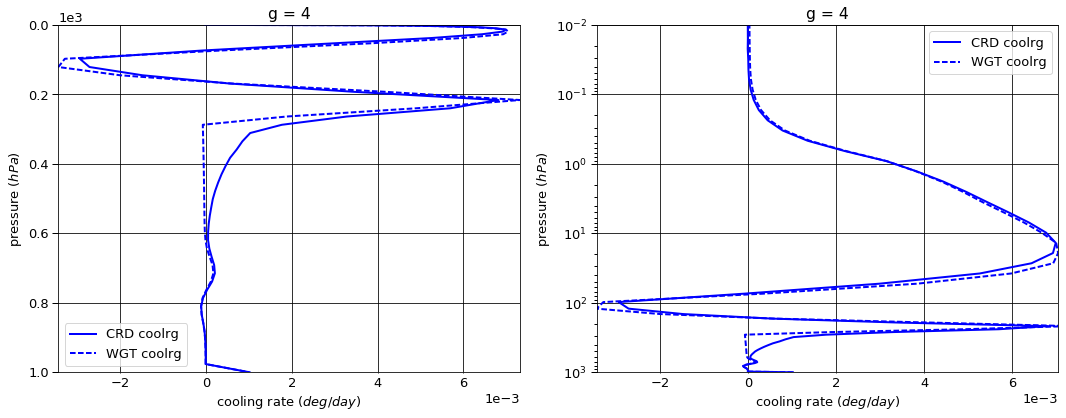

# Figure: cooling rate g-group 5

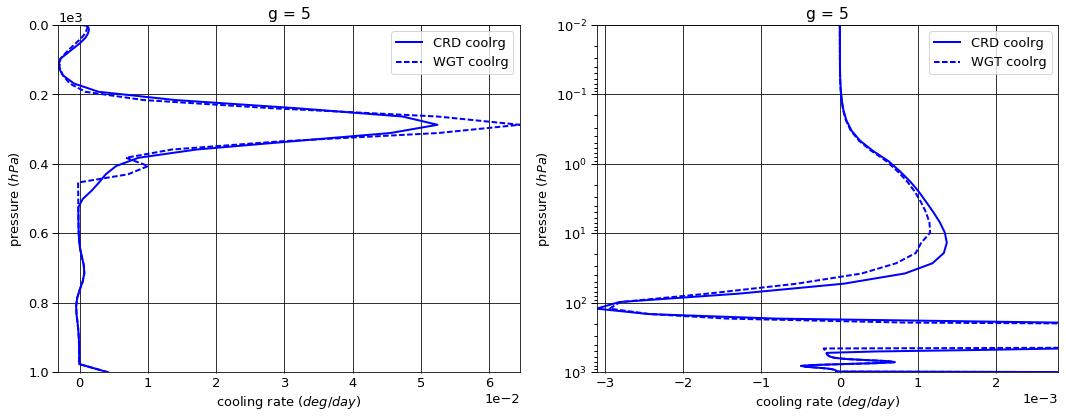

# Figure: cooling rate g-group 6

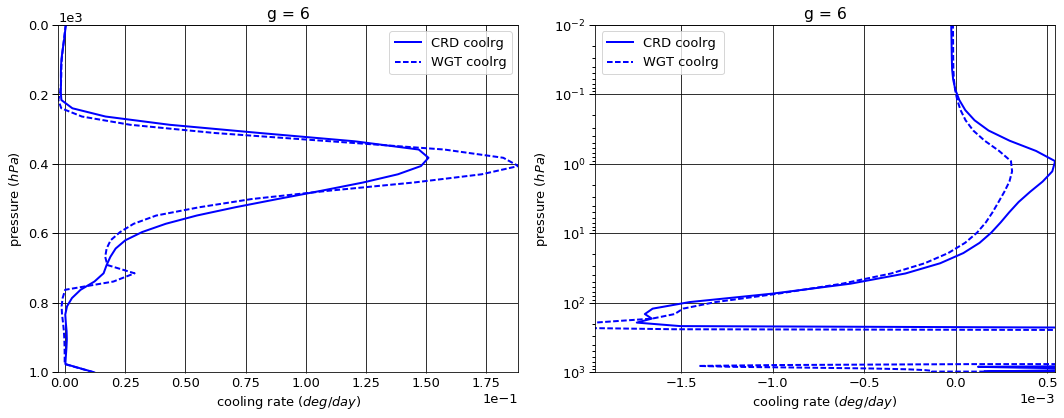

# Figure: cooling rate g-group 7

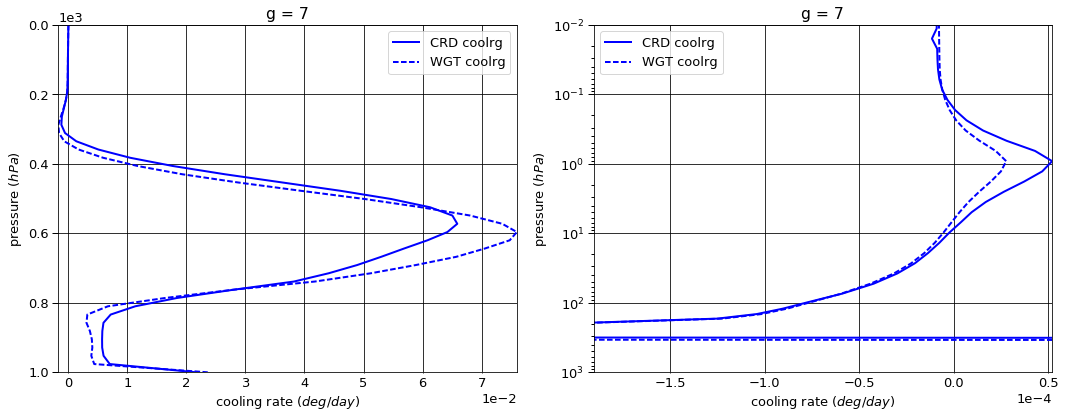

# Figure: cooling rate g-group total

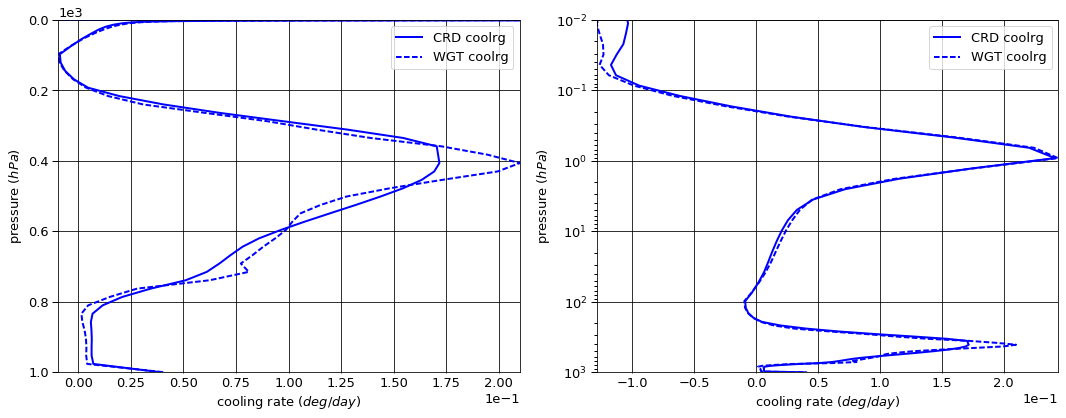

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.012978   0.000000 -0.012978
  1013.0   76     -0.053841   0.053749 -0.000091
2 0.0      1      -0.024167   0.000000 -0.024167
  1013.0   76     -0.119420   0.119218 -0.000202
3 0.0      1      -0.045621   0.000000 -0.045621
  1013.0   76     -0.437401   0.436655 -0.000746
4 0.0      1      -0.098606   0.000000 -0.098606
  1013.0   76     -1.691062   1.688187 -0.002874
5 0.0      1      -0.746356   0.000000 -0.746356
  1013.0   76     -7.017144   7.005253 -0.011891
6 0.0      1      -4.234676   0.000000 -4.234676
  1013.0   76    -19.923143  19.889142 -0.034000
7 0.0      1      -2.530820   0.000000 -2.530820
  1013.0   76     -6.613023   6.544669 -0.068354


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.013479   0.000000 -0.013479
  1013.0   76     -0.053841   0.053749 -0.000091
2 0.0      1      -0.024377   0.000000 -0.024377
  1013.0   76     -0.119420   0.119218 -0.000202
3 0.0      1      -0.037430   0.000000 -0.037430
  1013.0   76     -0.437401   0.436658 -0.000743
4 0.0      1      -0.074378   0.000000 -0.074378
  1013.0   76     -1.691062   1.688194 -0.002867
5 0.0      1      -0.766819   0.000000 -0.766819
  1013.0   76     -7.017144   7.005253 -0.011891
6 0.0      1      -4.249232   0.000000 -4.249232
  1013.0   76    -19.923143  19.889392 -0.033750
7 0.0      1      -2.573211   0.000000 -2.573211
  1013.0   76     -6.613023   6.548480 -0.064543


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000501  0.000000 -0.000501
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.000211  0.000000 -0.000211
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1      0.008192  0.000000  0.008192
  1013.0   76     0.000000  0.000002  0.000002
4 0.0      1      0.024228  0.000000  0.024228
  1013.0   76     0.000000  0.000007  0.000007
5 0.0      1     -0.020463  0.000000 -0.020463
  1013.0   76     0.000000  0.000000  0.000000
6 0.0      1     -0.014556  0.000000 -0.014556
  1013.0   76     0.000000  0.000250  0.000250
7 0.0      1     -0.042391  0.000000 -0.042391
  1013.0   76     0.000000  0.003812  0.003812

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.101105
  1001.112500 75     0.000032
2 0.000312    1     -0.019000
  1001.112500 75     0.000071
3 0.000312    1     -0.000283
  1001.112500 75     0.000263
4 0.000312    1     -0.000022
  1001.112500 75     0.001015
5 0.000312    1     -0.000001
  1001.112500 75     0.004197
6 0.000312    1     -0.000031
  1001.112500 75     0.012106
7 0.000312    1     -0.000010
  1001.112500 75     0.021672


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.127588
  1001.112500 75     0.000032
2 0.000312    1     -0.010691
  1001.112500 75     0.000071
3 0.000312    1     -0.000137
  1001.112500 75     0.000262
4 0.000312    1      0.000014
  1001.112500 75     0.001012
5 0.000312    1     -0.000001
  1001.112500 75     0.004197
6 0.000312    1     -0.000019
  1001.112500 75     0.011911
7 0.000312    1     -0.000008
  1001.112500 75     0.023614


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.648256e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.308539e-03
  1001.112500 75     0.000000e+00
3 0.000312    1      1.465105e-04
  1001.112500 75    -8.795600e-07
4 0.000312    1      3.586776e-05
  1001.112500 75    -3.119900e-06
5 0.000312    1      2.105900e-07
  1001.112500 75     0.000000e+00
6 0.000312    1      1.179137e-05
  1001.112500 75    -1.948320e-04
7 0.000312    1      1.532853e-06
  1001.112500 75     1.942242e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.693224,0.000000,-7.693224
1013.0,76,-35.855034,35.736874,-0.118159



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.738926,0.000000,-7.738926
1013.0,76,-35.855034,35.740945,-0.114088



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.045702,0.000000,-0.045702
1013.0,76,0.000000,0.004071,0.004071


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.120452
1001.112500,75,0.039356



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.138430
1001.112500,75,0.041099



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.017978
1001.112500,75,0.001743


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001452,0.001495
2,0.003240,0.003333
3,0.011856,0.012140
4,0.045250,0.047069
5,0.186990,0.195494
6,0.543010,0.556468
7,0.208202,0.184001


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.887171e-18
2,1.278086e-19
3,5.657798e-21
4,2.489067e-21
5,5.350613e-21
6,2.411227e-22
7,1.086608e-23


In [21]:
def spreadsheet():
    ng = 7
    ng_refs = [3, 1, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.887171e-18,NaN,0.001452,0.001495,0.001452,0.001495,1.0
2,1.278086e-19,0.044268,0.003240,0.003333,0.004692,0.004828,1.0
3,5.657798e-21,0.044268,0.011856,0.012140,0.016548,0.016968,1.0
4,2.489067e-21,0.439936,0.045250,0.047069,0.061798,0.064037,10.0
5,5.350613e-21,2.149646,0.186990,0.195494,0.248788,0.259531,500.0
6,2.411227e-22,0.045065,0.543010,0.556468,0.791798,0.815999,500.0
7,1.086608e-23,0.045065,0.208202,0.184001,1.000000,1.000000,500.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.284341e-17  5.491534e-18   2.338766
      2     0.000312  4.846636e-19  1.625277e-19   2.982036
      3     0.000312  7.542365e-21  2.403004e-21   3.138724
      4     0.000312  1.434613e-22  8.997723e-23   1.594418
      5     0.000312  6.452295e-24  5.814578e-24   1.109675
      6     0.000312  8.955095e-24  2.781334e-24   3.219712
      7     0.000312  4.439128e-24  2.327299e-25  19.074164
2     1     0.000750  1.284471e-17  5.500031e-18   2.335388
      2     0.000750  4.864750e-19  1.630553e-19   2.983496
      3     0.000750  7.577845e-21  2.417177e-21   3.134998
      4     0.000750  1.443966e-22  9.077726e-23   1.590670
      5     0.000750  6.488276e-24  5.850447e-24   1.109022
      6     0.000750  8.975613e-24  2.790895e-24   3.216034
      7     0.000750  4.443985e-24  2.333534e-25  19.044011
3     1     0.001052  1.284738e-17  5.517158e-18   2.328623
      2     0.001052  4.901172e-19  1.640789e-19   2.987083
      3     0.001052  7.642592e-21  2.436895e-21   3.136201
      4     0.001052  1.456772e-22  9.176614e-23   1.587483
      5     0.001052  6.529962e-24  5.891916e-24   1.108292
      6     0.001052  9.015451e-24  2.808172e-24   3.210434
      7     0.001052  4.453897e-24  2.344608e-25  18.996336
4     1     0.001476  1.284991e-17  5.534477e-18   2.321792
      2     0.001476  4.938325e-19  1.651310e-19   2.990550
      3     0.001476  7.710635e-21  2.459151e-21   3.135487
      4     0.001476  1.471174e-22  9.290581e-23   1.583512
      5     0.001476  6.579047e-24  5.940739e-24   1.107446
      6     0.001476  9.057022e-24  2.826273e-24   3.204582
      7     0.001476  4.464274e-24  2.356220e-25  18.946765
5     1     0.002070  1.285224e-17  5.551757e-18   2.314986
      2     0.002070  4.975742e-19  1.662019e-19   2.993794
      3     0.002070  7.781802e-21  2.484569e-21   3.132053
      4     0.002070  1.487573e-22  9.424341e-23   1.578437
      5     0.002070  6.637850e-24  5.999241e-24   1.106448
      6     0.002070  9.100006e-24  2.845163e-24   3.198413
      7     0.002070  4.475001e-24  2.368363e-25  18.894913
6     1     0.002904  1.285436e-17  5.568996e-18   2.308201
      2     0.002904  5.013456e-19  1.672967e-19   2.996745
      3     0.002904  7.856988e-21  2.514203e-21   3.125041
      4     0.002904  1.506703e-22  9.585315e-23   1.571887
      5     0.002904  6.710096e-24  6.071150e-24   1.105243
      6     0.002904  9.144674e-24  2.865098e-24   3.191749
      7     0.002904  4.486097e-24  2.381228e-25  18.839426
7     1     0.004074  1.285625e-17  5.586198e-18   2.301431
      2     0.004074  5.051524e-19  1.684242e-19   2.999287
      3     0.004074  7.937465e-21  2.549685e-21   3.113117
      4     0.004074  1.529602e-22  9.784054e-23   1.563362
      5     0.004074  6.801021e-24  6.161697e-24   1.103758
      6     0.004074  9.191414e-24  2.886449e-24   3.184333
      7     0.004074  4.497590e-24  2.395091e-25  18.778370
8     1     0.005714  1.285786e-17  5.603382e-18   2.294661
      2     0.005714  5.090054e-19  1.695970e-19   3.001264
      3     0.005714  8.025061e-21  2.593287e-21   3.094551
      4     0.005714  1.557728e-22  1.003547e-22   1.552222
      5     0.005714  6.917983e-24  6.278238e-24   1.101899
      6     0.005714  9.240794e-24  2.909746e-24   3.175808
      7     0.005714  4.509527e-24  2.410347e-25  18.709035
9     1     0.008015  1.285916e-17  5.620554e-18   2.287881
      2     0.008015  5.129152e-19  1.708318e-19   3.002458
      3     0.008015  8.122252e-21  2.648117e-21   3.067180
      4     0.008015  1.593115e-22  1.036031e-22   1.537710
      5     0.008015  7.071271e-24  6.431061e-24   1.099550
      6     0.008015  9.293556e-24  2.935718e-24   3.165684
      7     0.008015  4.521956e-24  2.427541e-25  18.627721
10    1     0.011243  1.286007e-17  5.637737e-18   2.281068
      2     0.011243  5.168999e-19  1.721526e-19   3

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
